In [1]:
import pandas as pd
import numpy as np
import json
from scipy.stats import poisson
import re

# Mute warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Cargar Datos
df_historico = pd.read_csv('C:/Users/Nancy Sorroza Rojas/Desktop/Pool/Proyectos Data Science/WorldCup Tournament 2026/Data/clean_fifa_worldcup_historical_data.csv', delimiter=',')
df_fixture = pd.read_csv('C:/Users/Nancy Sorroza Rojas/Desktop/Pool/Proyectos Data Science/WorldCup Tournament 2026/Data/format_fixture_data.csv', delimiter=',')
with open("C:/Users/Nancy Sorroza Rojas/Desktop/Pool/Proyectos Data Science/WorldCup Tournament 2026/Data/grupos_2026.json", "r", encoding="utf-8") as f:
    grupos_2026 = json.load(f)
# Crear un diccionario donde cada grupo sea un DataFrame
dict_table = {grupo: pd.DataFrame(lista_dicc) for grupo, lista_dicc in grupos_2026.items()}

In [3]:
print('Dimension of df_historico',df_historico.shape)
print('Dimension of df_fixture',df_fixture.shape)
df_historico.head()

Dimension of df_historico (965, 6)
Dimension of df_fixture (104, 4)


,home,away,year,home_goals,away_goals,total_goals
0,France,Mexico,1930,4.0,1.0,5.0
1,Argentina,France,1930,1.0,0.0,1.0
2,Chile,Mexico,1930,3.0,0.0,3.0
3,Chile,France,1930,1.0,0.0,1.0
4,Argentina,Mexico,1930,6.0,3.0,9.0


# Team Strength

In [4]:
df_home = df_historico[['home', 'home_goals', 'away_goals']]
df_away = df_historico[['away', 'home_goals', 'away_goals']]
df_home = df_home.rename(columns={'home': 'team', 'home_goals': 'goals_scored', 'away_goals': 'goals_conceded'})
df_away = df_away.rename(columns={'away': 'team', 'home_goals': 'goals_conceded', 'away_goals': 'goals_scored'})
df_team_strength = pd.concat([df_home, df_away], ignore_index=True).groupby('team').mean()
df_team_strength.head()

,goals_scored,goals_conceded
team,,
Algeria,1.000000,1.461538
Angola,0.333333,0.666667
Argentina,1.727273,1.147727
Australia,0.850000,1.850000
Austria,1.482759,1.620690


# Predicting World Cup

In [5]:
# Slicing the df_fixture 
df_fixture_group_72 = df_fixture[:72].copy()                # 72 partidos
df_fixture_round_of_32 = df_fixture[72:88].copy()            # 16 partidos
df_fixture_round_of_16 = df_fixture[88:96].copy()            # 8 partidos
df_fixture_quarter = df_fixture[96:100].copy()               # 4 partidos
df_fixture_semi = df_fixture[100:102].copy()                 # 2 partidos
df_fixture_third_place_playoff = df_fixture[102:103].copy()  # 1 partido
df_fixture_final = df_fixture[103:104].copy()                # 1 partido

## Group stage

In [6]:
# Point for each Group
def predict_points(home, away):
    if home in df_team_strength.index and away in df_team_strength.index:
        # goals_scored * goals_conceded
        lamb_home = df_team_strength.at[home,'goals_scored'] * df_team_strength.at[away,'goals_conceded']
        lamb_away = df_team_strength.at[away,'goals_scored'] * df_team_strength.at[home,'goals_conceded']
        prob_home, prob_away, prob_draw = 0, 0, 0
        for x in range(0,11): #number of goals home team
            for y in range(0, 11): #number of goals away team
                p = poisson.pmf(x, lamb_home) * poisson.pmf(y, lamb_away)
                if x == y:
                    prob_draw += p
                elif x > y:
                    prob_home += p
                else:
                    prob_away += p
        
        points_home = 3 * prob_home + prob_draw
        points_away = 3 * prob_away + prob_draw
        return (points_home, points_away)
    else:
        return (0, 0)
        
for group in dict_table:
    teams_in_group = dict_table[group]['Team'].values
    df_fixture_group_6 = df_fixture_group_72[df_fixture_group_72['home'].isin(teams_in_group)]
    for index, row in df_fixture_group_6.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        dict_table[group].loc[dict_table[group]['Team'] == home, 'Pts'] += points_home
        dict_table[group].loc[dict_table[group]['Team'] == away, 'Pts'] += points_away
    dict_table[group] = dict_table[group].sort_values('Pts', ascending=False).reset_index()
    dict_table[group] = dict_table[group][['Team', 'Pts']]
    dict_table[group] = dict_table[group].round(0)

# View of the 'Group 1'
print(dict_table['Grupo A'])

           Team  Pts
0         Chile  6.0
1          Peru  5.0
2        Mexico  5.0
3  Saudi Arabia  2.0


# Round of 32

In [7]:
df_fixture_round_of_32

,home,score,away,year
72,Runner-up Group A,Match 73,Runner-up Group B,2026
73,Winner Group E,Match 74,3rd Group A/B/C/D/F,2026
74,Winner Group F,Match 75,Runner-up Group C,2026
75,Winner Group C,Match 76,Runner-up Group F,2026
76,Winner Group I,Match 77,3rd Group C/D/F/G/H,2026
77,Runner-up Group E,Match 78,Runner-up Group I,2026
78,Winner Group A,Match 79,3rd Group C/E/F/H/I,2026
79,Winner Group L,Match 80,3rd Group E/H/I/J/K,2026
80,Winner Group D,Match 81,3rd Group B/E/F/I/J,2026
81,Winner Group G,Match 82,3rd Group A/E/H/I/J,2026


In [8]:
# Replace the labels with the Winners, Runner-up and 3rd Group in the Round 32
def get_team(group_label, dict_table):
    # Winner Group A
    match = re.match(r"Winner Group ([A-L])", group_label)
    if match:
        letra = match.group(1)
        grupo = f"Grupo {letra}"
        return dict_table[grupo].loc[0, "Team"]  # Winner = fila 0
    # Runner-up Group A
    match = re.match(r"Runner-up Group ([A-L])", group_label)
    if match:
        letra = match.group(1)
        grupo = f"Grupo {letra}"
        return dict_table[grupo].loc[1, "Team"]  # Runner-up = fila 1
    # 3rd Group A/B/C/D/E
    match = re.match(r"3rd Group ([A-L/]+)", group_label)
    if match:
        letras = match.group(1).split("/")  # Ej: ["A","B","C"]
        # Sacamos el tercero de cada grupo permitido
        terceros = []
        for letra in letras:
            grupo = f"Grupo {letra}"
            equipo_tercero = dict_table[grupo].loc[2, "Team"]  # third = fila 2
            terceros.append(equipo_tercero)
        # TODO: mejorar criterio (por Pts, GF, etc.) si quieres
        return terceros[0]  # por ahora devolvemos el primero
    return group_label  # si no calza ninguna regla
    
df_fixture_round_of_32["home"] = df_fixture_round_of_32["home"].apply(
    lambda x: get_team(x, dict_table)
)
df_fixture_round_of_32["away"] = df_fixture_round_of_32["away"].apply(
    lambda x: get_team(x, dict_table)
)
df_fixture_round_of_32["winner"] = "?"
df_fixture_round_of_32

,home,score,away,year,winner
72,Peru,Match 73,Iran,2026,?
73,Brazil,Match 74,Mexico,2026,?
74,France,Match 75,Belgium,2026,?
75,Argentina,Match 76,Senegal,2026,?
76,Spain,Match 77,Egypt,2026,?
77,Nigeria,Match 78,Japan,2026,?
78,Chile,Match 79,Egypt,2026,?
79,Croatia,Match 80,Switzerland,2026,?
80,Ecuador,Match 81,Canada,2026,?
81,Italy,Match 82,Mexico,2026,?


In [9]:
# Get winner in the Round 32
def get_winner(df_fixture_updated):
    for index, row in df_fixture_updated.iterrows():
        home, away = row['home'], row['away']
        points_home, points_away = predict_points(home, away)
        if points_home > points_away:
            winner = home
        else:
            winner = away
        df_fixture_updated.loc[index, 'winner'] = winner
    return df_fixture_updated

df_fixture_round_of_32 = get_winner(df_fixture_round_of_32)
df_fixture_round_of_32

,home,score,away,year,winner
72,Peru,Match 73,Iran,2026,Peru
73,Brazil,Match 74,Mexico,2026,Brazil
74,France,Match 75,Belgium,2026,France
75,Argentina,Match 76,Senegal,2026,Argentina
76,Spain,Match 77,Egypt,2026,Spain
77,Nigeria,Match 78,Japan,2026,Nigeria
78,Chile,Match 79,Egypt,2026,Chile
79,Croatia,Match 80,Switzerland,2026,Croatia
80,Ecuador,Match 81,Canada,2026,Ecuador
81,Italy,Match 82,Mexico,2026,Italy


# Round 16

In [10]:
df_fixture_round_of_16

,home,score,away,year
88,Winner Match 74,Match 89,Winner Match 77,2026
89,Winner Match 73,Match 90,Winner Match 75,2026
90,Winner Match 76,Match 91,Winner Match 78,2026
91,Winner Match 79,Match 92,Winner Match 80,2026
92,Winner Match 83,Match 93,Winner Match 84,2026
93,Winner Match 81,Match 94,Winner Match 82,2026
94,Winner Match 86,Match 95,Winner Match 88,2026
95,Winner Match 85,Match 96,Winner Match 87,2026


In [11]:
# Get Winners for the Round 16
def resolver_ganadores(df_fase_actual, df_fase_anterior):
    df = df_fase_actual.copy()
    # Expresión para detectar textos tipo "Winner Match 74"
    patron = r"Winner Match (\d+)"
    for col in ["home", "away"]:
        df[col] = df[col].apply(lambda x: reemplazar(x, df_fase_anterior, patron))
    return df
def reemplazar(valor, df_prev, patron):
    # Si NO es un valor tipo "Winner Match XX", se devuelve igual
    m = re.match(patron, str(valor))
    if not m:
        return valor
    match_num = m.group(1)
    # Buscar en score == "Match XX"
    fila = df_prev[df_prev["score"] == f"Match {match_num}"]
    if fila.empty:
        return valor  # NO encontrado
    return fila["winner"].values[0]
    
df_fixture_round_of_16 = resolver_ganadores(df_fixture_round_of_16, df_fixture_round_of_32)
df_fixture_round_of_16["winner"] = "?"
df_fixture_round_of_16

,home,score,away,year,winner
88,Brazil,Match 89,Spain,2026,?
89,Peru,Match 90,France,2026,?
90,Argentina,Match 91,Nigeria,2026,?
91,Chile,Match 92,Croatia,2026,?
92,Uruguay,Match 93,Portugal,2026,?
93,Ecuador,Match 94,Italy,2026,?
94,Germany,Match 95,England,2026,?
95,Denmark,Match 96,Netherlands,2026,?


In [12]:
# Get Winner in Round 16
df_fixture_round_of_16 = get_winner(df_fixture_round_of_16)
df_fixture_round_of_16

,home,score,away,year,winner
88,Brazil,Match 89,Spain,2026,Brazil
89,Peru,Match 90,France,2026,France
90,Argentina,Match 91,Nigeria,2026,Argentina
91,Chile,Match 92,Croatia,2026,Croatia
92,Uruguay,Match 93,Portugal,2026,Portugal
93,Ecuador,Match 94,Italy,2026,Italy
94,Germany,Match 95,England,2026,Germany
95,Denmark,Match 96,Netherlands,2026,Netherlands


# Quarterfinals

In [13]:
df_fixture_quarter

,home,score,away,year
96,Winner Match 89,Match 97,Winner Match 90,2026
97,Winner Match 93,Match 98,Winner Match 94,2026
98,Winner Match 91,Match 99,Winner Match 92,2026
99,Winner Match 95,Match 100,Winner Match 96,2026


In [14]:
# Get Quarterfinals
df_fixture_quarter = resolver_ganadores(df_fixture_quarter, df_fixture_round_of_16)
df_fixture_quarter["winner"] = "?"
df_fixture_quarter

,home,score,away,year,winner
96,Brazil,Match 97,France,2026,?
97,Portugal,Match 98,Italy,2026,?
98,Argentina,Match 99,Croatia,2026,?
99,Germany,Match 100,Netherlands,2026,?


In [15]:
# Get Winner in Quarterfinals
df_fixture_quarter = get_winner(df_fixture_quarter)
df_fixture_quarter

,home,score,away,year,winner
96,Brazil,Match 97,France,2026,Brazil
97,Portugal,Match 98,Italy,2026,Italy
98,Argentina,Match 99,Croatia,2026,Argentina
99,Germany,Match 100,Netherlands,2026,Germany


# Semifinals

In [16]:
df_fixture_semi

,home,score,away,year
100,Winner Match 97,Match 101,Winner Match 98,2026
101,Winner Match 99,Match 102,Winner Match 100,2026


In [17]:
# Get Semifinals
df_fixture_semi = resolver_ganadores(df_fixture_semi, df_fixture_quarter)
df_fixture_semi["winner"] = "?"
df_fixture_semi

,home,score,away,year,winner
100,Brazil,Match 101,Italy,2026,?
101,Argentina,Match 102,Germany,2026,?


In [18]:
# Get Winner in Semifinals
df_fixture_semi = get_winner(df_fixture_semi)
df_fixture_semi

,home,score,away,year,winner
100,Brazil,Match 101,Italy,2026,Brazil
101,Argentina,Match 102,Germany,2026,Germany


# Third place playoff

In [19]:
df_fixture_third_place_playoff 

,home,score,away,year
102,Loser Match 101,Match 103,Loser Match 102,2026


In [20]:
def fill_losers(df_prev, df_curr):
    # Creamos diccionario match -> (home, away, winner)
    match_info = dict()
    # Usamos la columna 'score' que tiene "Match 101", "Match 102", etc.
    for _, row in df_prev.iterrows():
        match_num = int(re.findall(r'\d+', row['score'])[0])
        winner = row['winner']
        home = row['home']
        away = row['away']
        loser = away if winner == home else home
        match_info[match_num] = {"winner": winner, "loser": loser}
    # Reemplazo dinámico
    def replace(text):
        m = re.search(r'Loser Match (\d+)', text)
        if not m:
            return text
        match_num = int(m.group(1))
        return match_info[match_num]["loser"]
    df_curr['home']  = df_curr['home'].apply(replace)
    df_curr['away']  = df_curr['away'].apply(replace)
    # Añadimos columna winner como placeholder
    df_curr['winner'] = '?'
    return df_curr

df_fixture_third_place_playoff = fill_losers(
    df_fixture_semi,
    df_fixture_third_place_playoff
)
df_fixture_third_place_playoff

,home,score,away,year,winner
102,Italy,Match 103,Argentina,2026,?


In [21]:
# Get Winner in Semifinals
df_fixture_third_place_playoff = get_winner(df_fixture_third_place_playoff)
df_fixture_third_place_playoff

,home,score,away,year,winner
102,Italy,Match 103,Argentina,2026,Italy


# Final

In [22]:
df_fixture_final

,home,score,away,year
103,Winner Match 101,Match 104,Winner Match 102,2026


In [23]:
# Get Final
df_fixture_final = resolver_ganadores(df_fixture_final, df_fixture_semi)
df_fixture_final["winner"] = "?"
df_fixture_final

,home,score,away,year,winner
103,Brazil,Match 104,Germany,2026,?


In [24]:
# Get Winner in Semifinals
df_fixture_final = get_winner(df_fixture_final)
df_fixture_final

,home,score,away,year,winner
103,Brazil,Match 104,Germany,2026,Brazil


# The final prediction is:
# WINNER OF THE FIFA WORLDCUP 2026 IS **BRAZIL**

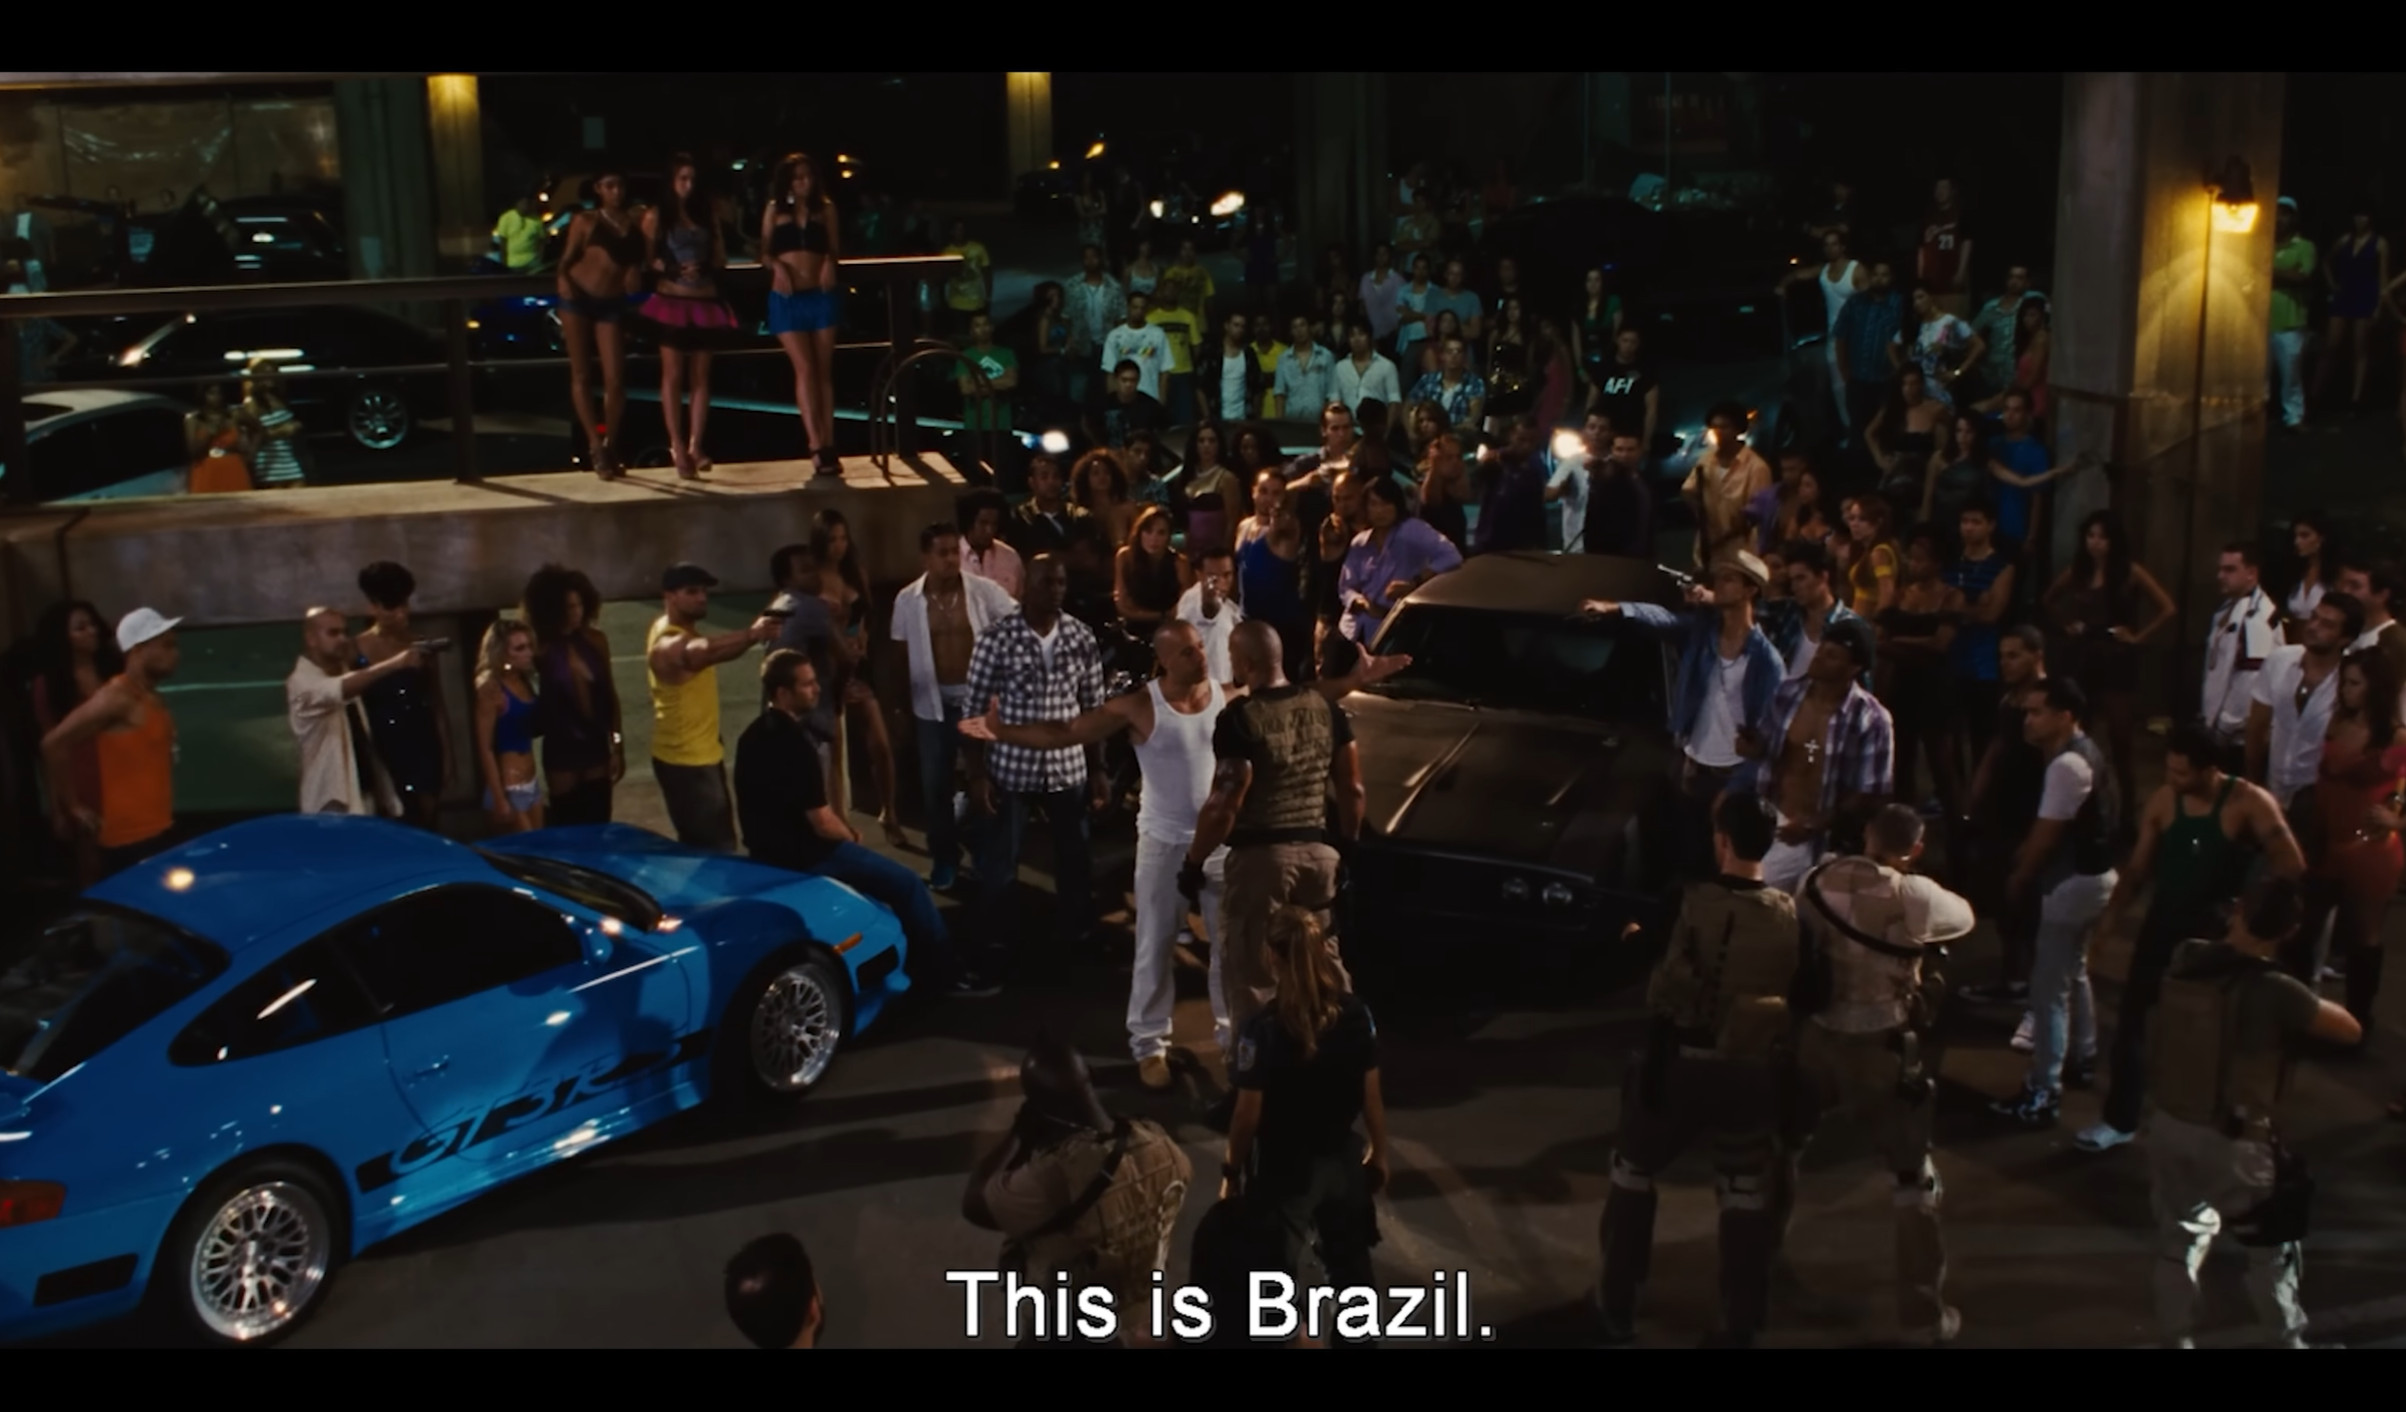

In [25]:
from IPython.display import Image, display
ruta = r"C:/Users/Nancy Sorroza Rojas/Desktop/Pool/Proyectos Data Science/WorldCup Tournament 2026/Captura de pantalla 2025-11-15 201959.png"
display(Image(filename=ruta))